In [23]:
#%run matplotlib_setup.ipy

from types import SimpleNamespace
from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 
from math import floor
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
import kwant
from kwant.wraparound import wraparound, plot_2d_bands

Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

a,b,c,d = Zigzag.sublattices


def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1] + 0.01
    
def get_length(L=8): 
    return L/4*Zigzag.prim_vecs[0][0]
    
def make_1D_zigzag(N=7,L=8):
    #syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    #syst = kwant.Builder(kwant.TranslationalSymmetry([get_length(L),0]))
    syst = kwant.Builder()
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N) and 0 <= pos[0] < get_length(L)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

def terminate_edges(syst): 
    sites = list(syst.sites())
    #print(sites)
    nsites = len(sites)
    pos = np.array([site.pos for site in sites])
    tags = [site.tag for site in sites]
    family = [site.family for site in sites]
    ymax = np.max(pos[:,1])
    ymin = np.min(pos[:,1])
    edge_index = []
    for i,p in enumerate(pos): 
        if abs(p[1] - ymax) < 1.e-2 or abs(p[1]-ymin) < 1.e-2: 
            edge_index.append(i)
    nedges = len(edge_index)
    #print(edge_index)
    edge_hoping_pairs = []
    for i in range(nedges): 
        site1 = sites[edge_index[i]]
        #print(site1.pos)
        neigh_sites = syst.neighbors(site1)
        for site2 in neigh_sites: 
            if abs(site2.pos[1] - ymax) < 1.0e-2  or abs(site2.pos[1]-ymin)< 1.0e-2:
                hop_pair = [site1.tag,site2.tag]
                pair_seen = hop_pair in edge_hoping_pairs
                if not pair_seen:
                    syst[site1,site2] = -1 - 0.5
                    edge_hoping_pairs.append([site1.tag,site2.tag])
                    #print(site1.pos)
                    #print(site2.pos)
    #print(edge_hoping_pairs)
    #print(edge_index)           
    return syst

def finite_to_1D(system,lat_vec,trans_sym_direction='x'): 
    """Adds a translational symmetry on a finite system
    Useful for making complex geometries eg: cove-edged and chevron ribbon
    
    Parameters
    ==========
        system: instance of the finite system
        lat_vec: lattice vector of the translational symmetry 
        trans_sym_direction: 'x' or 'y' , direction of the translational symmetry
        
    TODO: 
    1. Currently only works for orthorhombic unit cells 
    2. Get the onsite and hopping values directly from the passed system
        Currently hard set inside the code"""
    
    sites = list(system.sites())
    pos = [site.pos for site in sites] 
    if trans_sym_direction=='x':
        a = lat_vec
        b = max(np.array(pos)[:,1])
        trans_vec=[a,0]
    elif trans_sym_direction=='y':
        a = max(np.array(pos)[:,0])
        b = lat_vec
        trans_vec=[0,b]
    else: 
        raise #"Translation Symmetry direction should be 'x' or 'y'"
    lattice_1D = kwant.lattice.general([[a,0],[0,b]],pos)
    system_1D = kwant.Builder(kwant.TranslationalSymmetry(trans_vec))
    if trans_sym_direction=='x':
        system_1D[lattice_1D.shape((lambda pos: 0< pos[1] <= b),(0,0))]=0 
    if trans_sym_direction=='y':
        system_1D[lattice_1D.shape((lambda pos: 0< pos[0] <= a),(0,0))]=0 
    system_1D[lattice_1D.neighbors(2)] = -1
    return system_1D 

def get_pol_custom(syst):
    pos = [ site.pos for  site in syst.sites()]
    nsites = len(pos)
    syst = syst.finalized()
    kwant.plotter.bands(syst)
    lattice = kwant.lattice.general([[get_length(4),0],[0,get_width(16)]],pos)
    act_pos = np.array([syst.pos(i) for i in range(nsites)])
    a1,a2 = [lattice.prim_vecs[0][0],get_width(N=7)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(syst,momenta=1001,dim=2)
    z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=1)
    result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

    print("Polarization:",result.pol)
    
def make_junction(syst1,syst2,lx1,lx2,ly,xoff=0,yoff=0):
    lx = lx1 + lx2
    nx = 1
    nx1 = nx 
    nx2 = nx
    pos_all0 = []
    for i in range(nx1):
        pos1 =  [[site.pos[0] + i*lx1,site.pos[1]] for site in syst1.sites()]
        pos_all0 += pos1
    for i in range(nx2): 
        pos2 =  [[site.pos[0] + nx1*lx1 + i*lx2+xoff,site.pos[1]+yoff] for site in syst2.sites()]
        pos_all0 += pos2
    pos_all = pos_all0

    min_y = np.min(np.array(pos_all)[:,1])
    lat = kwant.lattice.general([[nx*lx,0],[0,2*ly]],pos_all,norbs=1)
    syst = kwant.Builder(kwant.TranslationalSymmetry([lx,0]))
    #syst = kwant.Builder()
    syst[lat.shape((lambda pos: 0< pos[0]< nx*lx and min_y - yoff<=pos[1]<ly+yoff),(0,0))] = 0 
    syst[lat.neighbors()] = -1 
    print(len(pos1),len(pos2),len(pos_all))
    return syst 

def plot_wf(syst,i_start,i_end,ham):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",eig_val[i], "x t")
        fig = kwant.plotter.map(syst,abs(eig_vec[:,i])**2,oversampling=3,fig_size=(16,10))
        
        #fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))
    
def check_junction(syst1,syst2,lx1,lx2,ly=14,xoff=0,yoff=0):
    syst = make_junction(syst1,syst2,lx1,lx2,ly,xoff,yoff)
    #syst.eradicate_dangling()
    kwant.plot(syst,site_color='black',fig_size=(16,10));
    
    nbands = len(syst.sites())
    n1 = int(nbands/2 -5)
    n2 = int(nbands/2 +5)
    print('Number of bands in junction is {}'.format(nbands))
    
    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix() 
    fig = plot_wf(syst,n1,n2,ham)

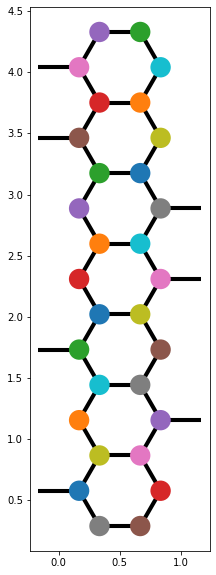

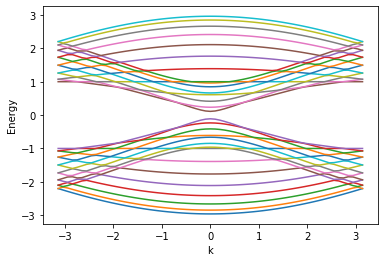

0.11114046603920445


In [33]:
wide = make_1D_zigzag(N=15,L=4)
wide = finite_to_1D(wide,1)
kwant.plot(wide,fig_size=(16,10));
kwant.plotter.bands(wide.finalized());
bands = kwant.physics.Bands(wide.finalized()) 
energies = bands(0)
print(np.min(np.abs(energies)))

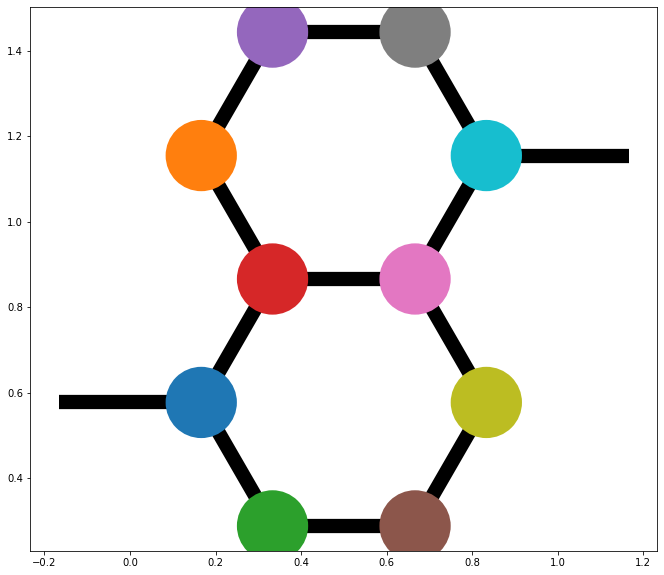

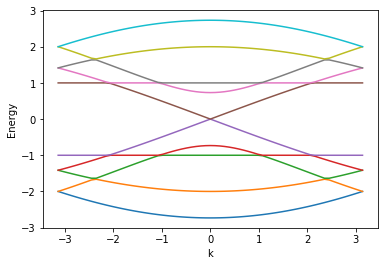

2.502485666807538e-16


In [40]:
narrow = make_1D_zigzag(N=5,L=4)
narrow = finite_to_1D(narrow,1)
kwant.plot(narrow,fig_size=(16,10));
kwant.plotter.bands(narrow.finalized());
bands = kwant.physics.Bands(narrow.finalized()) 
energies = bands(0)
print(np.min(np.abs(energies)))

30 10 40


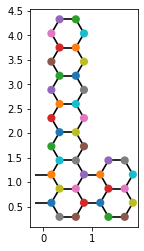

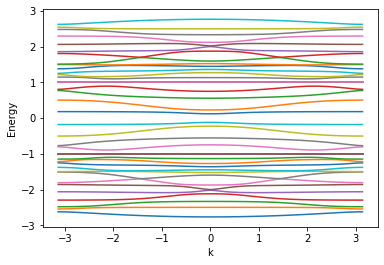

0.12001285957687448
30 10 40


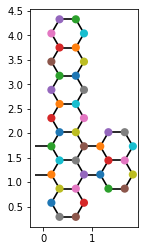

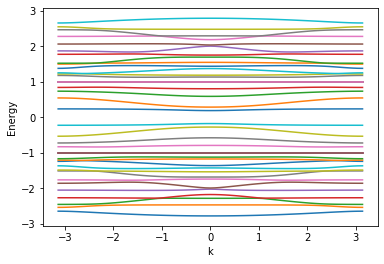

0.18291101055751677
30 10 40


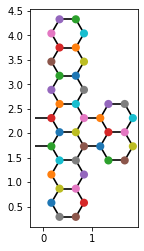

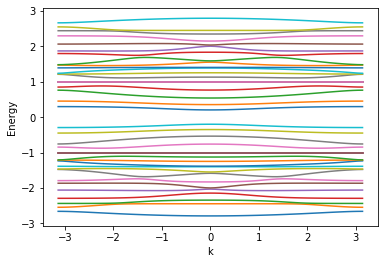

0.20192223342409338
30 10 40


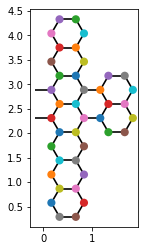

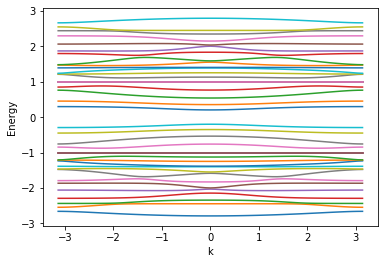

0.20192223342409327
30 10 40


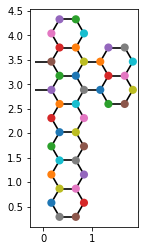

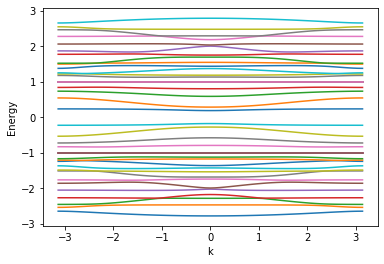

0.1829110105575165
30 10 40


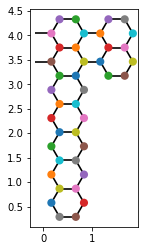

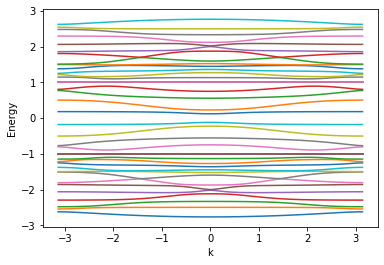

0.12001285957687448


In [43]:
for yn in range(6):
    comp_syst = make_junction(wide,narrow,1,1,12,yoff=yn*np.sqrt(3)/3)
    kwant.plot(comp_syst)
    kwant.plotter.bands(comp_syst.finalized());
    bands = kwant.physics.Bands(comp_syst.finalized()) 
    energies = bands(0)
    print(np.min(np.abs(energies)))

30 14 44


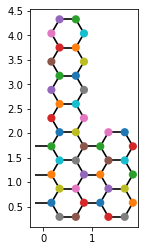

0.21573852794942766


In [31]:
comp_syst = make_junction(wide,narrow,1,1,12)
kwant.plot(comp_syst)
bands = kwant.physics.Bands(comp_syst.finalized()) 
energies = bands(0)
print(np.min(np.abs(energies)))